 # Part 1
# 1. Which democratic candidate will win in each county?

The following steps had to be taken:

1. First, we ask you to create the best possible model using the techniques
 you’ve learned in this course. For this question use the typical 75%/25%
 train/test split (make sure you split the data by a date of the primary
 election).

2. Second, show how performance of your best model on the test set decreases
 as the size of the training set decreases, visualize this result. Make sure
 you do allow the regularization parameter to vary for different training set
 sizes, also visualize how the optimal regularization parameter varies as the
 size of the training set changes.

3. Third, show which features are most important to make good predictions.



# Import and Prepare Data

In [1]:
import pandas as pd

county = 'county_facts.csv'

results = 'primary_results.csv'

county_data = pd.read_csv(county)

results_data = pd.read_csv(results)

In [2]:
### filter for democratic results 
democrat_results = results_data[results_data['party'].isin(['Democrat'])]
          
### only keep hill and bern
democrat_results = democrat_results[democrat_results['candidate'].isin(['Bernie Sanders', 'Hillary Clinton'])]    

In [3]:
# drop all 'whole' state rows and the USA row by checking if 'state_abbreviation' == NaN

# first make a list with indexes of the rows that have to be deleted 
indexes = []

index = 0 

for index, row in county_data.iterrows():
    
    if pd.isnull(row['state_abbreviation']):
        
        indexes.append(index)
        
    index += 1

# now drop these rows by index
county_data = county_data.drop(county_data.index[indexes])

# Create the y variable: 'democratic_winner'

In [4]:
# Create Dictionary with fips as keys and winner as value. Use to later acces the winner per row of the county data.
# (fips are the unique county codes)

dem_winners = {}
dem_winners_fips_missing = {}

for index, row in democrat_results.iterrows():
    
    # some county fips are missing, add to seperate dict to link them to the winner
    if pd.isnull(row['fips']) and row['candidate'] == 'Hillary Clinton':
        
        dem_winners_fips_missing[row['county']] = [row['state_abbreviation'], row['fraction_votes'],
                                                   'Hillary Clinton']
        
    elif row['candidate'] == 'Hillary Clinton':
        
        dem_winners[row['fips']] = ['Hillary Clinton', row['fraction_votes']]
    
  
            
for index, row in democrat_results.iterrows():
    
    if pd.isnull(row['fips']) and row['candidate'] == 'Bernie Sanders':
        
        if row['fraction_votes'] > dem_winners_fips_missing[row['county']][1]:
             
                dem_winners_fips_missing[row['county']] = [row['state_abbreviation'],
                                                        row['fraction_votes'], 'Bernie Sander']
        
        elif row['fraction_votes'] == dem_winners_fips_missing[row['county']][1]:
             
                dem_winners_fips_missing[row['county']] = [row['state_abbreviation'],'Tie']
    
    
    elif row['candidate'] == 'Bernie Sanders' and row['fraction_votes'] > dem_winners[row['fips']][1]:
        
        dem_winners[row['fips']][0] = 'Bernie Sanders'
        
    
    elif row['candidate'] == 'Bernie Sanders' and row['fraction_votes'] == dem_winners[row['fips']][1]:
        
        dem_winners[row['fips']][0] = 'Tie'

    
# for index, row in democrat_results.iterrows():
    
#     if row['fraction_votes'] == 0.5:
        
#         dem_winners[row['fips']] = 'Tie'

In [5]:
print(dem_winners_fips_missing)

##### You can see that all the rows where the unique county code is missing,Bernie is the winner. Wikipedia 
#### also confirms that he won all primaries in New Hampshire.
#### When we come across these rows when can therefore assume that he was the winner.

{'Belknap': ['NH', 0.6318565400843882, 'Bernie Sander'], 'Carroll': ['NH', 0.6364659538548115, 'Bernie Sander'], 'Cheshire': ['NH', 0.7070930430345297, 'Bernie Sander'], 'Coos': ['NH', 0.6437168141592919, 'Bernie Sander'], 'Grafton': ['NH', 0.6733094068757084, 'Bernie Sander'], 'Hillsborough': ['NH', 0.5790096636452169, 'Bernie Sander'], 'Merrimack': ['NH', 0.5968631335644708, 'Bernie Sander'], 'Rockingham': ['NH', 0.5765271105010296, 'Bernie Sander'], 'Strafford': ['NH', 0.6431930592718722, 'Bernie Sander'], 'Sullivan': ['NH', 0.702844222301559, 'Bernie Sander']}


In [6]:
# create the y column: 'democratic_winner'. Set values to 0 for now. Merge with the county data.

democratic_winner = {'democratic_winner' : [0] * len(county_data['fips'])}

democratic_winner_df = pd.DataFrame(data = democratic_winner)

democratic_data = pd.concat([county_data ,democratic_winner_df], axis = 1)


In [7]:
# Now set the values of the 'democratic_winner' column to the either Bernie, Hillary or Tie. Value stays 0 if 
# the county code is not in the result data-set, and therefore missing

for index, row in democratic_data.iterrows():
    
    # this is the if statement for where country fip is missing and berny is thus the winner. 
    if pd.isnull(row['fips']): 
        if row['area_name'] in dem_winners_fips_missing:
            democratic_data.loc[index, 'democratic_winner'] = 'Bernie Sanders'
    
    # otherwise look in the winner dict to see who was the winner
    elif row['fips'] in dem_winners:
        democratic_data.loc[index, 'democratic_winner'] = dem_winners[row['fips']][0]
    
    
    
# print(democratic_data)    

In [8]:
# remove all the rows where the y variable is missing : value 0

# this means that also the tie rows are dropped:
democratic_data_clean = democratic_data[democratic_data['democratic_winner'].isin \
                                        (['Hillary Clinton', 'Bernie Sanders'])]

# threshold for dropping row due to missing values is 55 (all features) - 1 (y variable) = 54
democratic_data_clean = democratic_data_clean.dropna(axis=0, thresh = 54)


In [9]:
# rename column names
democratic_data_clean.rename(index=str, columns={
'PST045214':"Population: 2014 estimate",
'PST040210':"Population: 2010 (April 1) estimates base",
'PST120214':"Population: percent change - April 1: 2010 to July 1: 2014",
'POP010210':"Population: 2010",
'AGE135214':"Persons under 5 years: percent: 2014",
'AGE295214':"Persons under 18 years: percent: 2014",
'AGE775214':"Persons 65 years and over: percent: 2014",
'SEX255214':"Female persons: percent: 2014",
'RHI125214':"White alone: percent: 2014",
'RHI225214':"Black or African American alone: percent: 2014",
'RHI325214':"American Indian and Alaska Native alone: percent: 2014",
'RHI425214':"Asian alone: percent: 2014",
'RHI525214':"Native Hawaiian and Other Pacific Islander alone: percent: 2014",
'RHI625214':"Two or More Races: percent: 2014",
'RHI725214':"Hispanic or Latino: percent: 2014",
'HI825214':"White alone: not Hispanic or Latino: percent: 2014",
'POP715213':"Living in same house 1 year & over: percent: 2009-2013",
'POP645213':"Foreign born persons: percent: 2009-2013",
'POP815213':"Language other than English spoken at home: pct age 5+: 2009-2013",
'EDU635213':"High school graduate or higher: percent of persons age 25+: 2009-2013",
'EDU685213':"Bachelor's degree or higher: percent of persons age 25+: 2009-2013",
'VET605213':"Veterans: 2009-2013",
'LFE305213':"Mean travel time to work (minutes): workers age 16+: 2009-2013",
'HSG010214':"Housing units: 2014",
'HSG445213':"Homeownership rate: 2009-2013",
'HSG096213':"Housing units in multi-unit structures: percent: 2009-2013",
'HSG495213':"Median value of owner-occupied housing units: 2009-2013",
'HSD410213':"Households: 2009-2013",
'HSD310213':"Persons per household: 2009-2013",
'INC910213':"Per capita money income in past 12 months (2013 dollars): 2009-2013",
'INC110213':"Median household income: 2009-2013",
'PVY020213':"Persons below poverty level: percent: 2009-2013",
'BZA010213':"Private nonfarm establishments: 2013",
'BZA110213':"Private nonfarm employment:  2013",
'BZA115213':"Private nonfarm employment: percent change: 2012-2013",
'NES010213':"Nonemployer establishments: 2013",
'SBO001207':"Total number of firms: 2007",
'SBO315207':"Black-owned firms: percent: 2007",
'SBO115207':"American Indian- and Alaska Native-owned firms: percent: 2007",
'SBO215207':"Asian-owned firms: percent: 2007",
'SBO515207':"Native Hawaiian- and Other Pacific Islander-owned firms: percent: 2007",
'SBO415207':"Hispanic-owned firms: percent: 2007",
'SBO015207':"Women-owned firms: percent: 2007",
'MAN450207':"Manufacturers shipments: 2007 ($1:000)",
'WTN220207':"Merchant wholesaler sales: 2007 ($1:000)",
'RTN130207':"Retail sales: 2007 ($1:000)",
'RTN131207':"Retail sales per capita: 2007",
'AFN120207':"Accommodation and food services sales: 2007 ($1:000)",
'BPS030214':"Building permits: 2014",
'LND110210':"Land area in square miles: 2010",
'POP060210':"Population per square mile: 2010"}, inplace=True)

# Create Train/Test Split 

In [10]:
# create train/test split 

from sklearn.utils import shuffle

# states for the test split where elections where after april 19 (makes about 30% of total population and 22% of rows): 
# Indiana, West Virginia, Oregon, California, Montana, New Jersey, New Mexico, North Dakota, South Dakota,
# Pennsylvania, Rhode Island, Connecticut, Delaware, Kentucky, and Maryland. 
# (See drive for ordering by date) 
# NB: nebraska is in the republican cutoff and not the democratic. And Kentucky not in the Republican 
# but is in the democratic.

democratic_data_test = democratic_data_clean[democratic_data_clean['state_abbreviation'].isin \
                                (['IN','WV','OR','CA','MT','NJ','NM','ND','SD','PA','RI','CT','DE','MD','KY'])]

democratic_data_train = democratic_data_clean[~ democratic_data_clean['state_abbreviation'].isin \
                                (['IN','WV','OR','CA','MT','NJ','NM','ND','SD','PA','RI','CT','DE','MD','KY'])]

######
###### create X and y for train and test data. 
######

# now that we do not need the fips and state abbriviations any more, only keep 
# the numeric values and remove 'fips'.
X_train_dem = democratic_data_train._get_numeric_data()

X_train_dem.drop(['fips'], axis=1, inplace=True)

y_train_dem = democratic_data_train['democratic_winner']


# same for test data 
X_TEST_dem = democratic_data_test._get_numeric_data()

X_TEST_dem.drop(['fips'], axis=1, inplace=True)

y_TEST_dem = democratic_data_test['democratic_winner']


# now shuffle them so that future partitioning is certainly random: seed = 123
X_train_dem, y_train_dem = shuffle(X_train_dem, y_train_dem, random_state = 123)

X_TEST_dem, y_TEST_dem = shuffle(X_TEST_dem, y_TEST_dem, random_state = 123)


In [11]:
# for index, row in X_train_dem.iterrows():
#     print(row)

print(len(democratic_data_train))
print(len(democratic_data_test))

2143
626


# Model Test

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


logreg_model = cross_val_score(LogisticRegression(), X_train_dem, y_train_dem, cv = 10)

print(logreg_model)
print(np.mean(logreg_model))

[ 0.71162791  0.75813953  0.71162791  0.70560748  0.67757009  0.72897196
  0.71962617  0.78037383  0.74299065  0.67757009]
0.721410562921


For each of these tasks we have three questions:
# Creating the best possible model
1) First, we ask you to create the best possible model using the techniques you’ve learned in this course. For this question use the typical 75%/25% train/test split (make sure you split the data by a date of the primary election).

### KNN

In [13]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 50)}
grid = GridSearchCV(knn_pipe, param_grid, cv=5)
grid.fit(X_train_dem, y_train_dem)
print("The best performance: {:.3f}".format(grid.score(X_train_dem, y_train_dem)))
print("The corresponding number n of neighbors is: {}".format(grid.best_params_['kneighborsclassifier__n_neighbors']))

The best performance: 0.839
The corresponding number n of neighbors is: 12


### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=123))
param_grid = {'logisticregression__C': np.logspace(-6,3,14)}
grid = GridSearchCV(logreg_pipe, param_grid, cv=5)
grid.fit(X_train_dem, y_train_dem)
print("The best performance: {:.3f}".format(grid.score(X_train_dem, y_train_dem)))
print("The corresponding regularization parameter C is: {:.3f}".format(grid.best_params_['logisticregression__C']))

The best performance: 0.846
The corresponding regularization parameter C is: 1000.000


### LinearSVC

In [15]:
from sklearn.svm import LinearSVC
logreg_pipe = make_pipeline(MinMaxScaler(), LinearSVC(random_state=123))
param_grid = {'linearsvc__C': np.logspace(-6,3,14)}
grid = GridSearchCV(logreg_pipe, param_grid, cv=5)
grid.fit(X_train_dem, y_train_dem)
print("The best performance: {:.3f}".format(grid.score(X_train_dem, y_train_dem)))
print("The corresponding regularization parameter C is: {:.3f}".format(grid.best_params_['linearsvc__C']))

The best performance: 0.845
The corresponding regularization parameter C is: 41.246


### Polynomial Features

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
logreg_pipe = make_pipeline(PolynomialFeatures(),StandardScaler(), LogisticRegression(random_state=123))
param_grid = {'logisticregression__C': np.logspace(-6,3,14)}
grid = GridSearchCV(logreg_pipe, param_grid, cv=5)
grid.fit(X_train_dem, y_train_dem)
print("The best performance: {:.3f}".format(grid.score(X_train_dem, y_train_dem)))
print("The corresponding regularization parameter C is: {:.3f}".format(grid.best_params_['logisticregression__C']))

The best performance: 0.894
The corresponding regularization parameter C is: 0.346


# Changes in training set size
2) Second, show how performance of your best model on the test set decreases as the size of the training set decreases, visualize this result. Make sure you do allow the regularization parameter to vary for different training set sizes, also visualize how the optimal regularization parameter varies as the size of the training set changes.

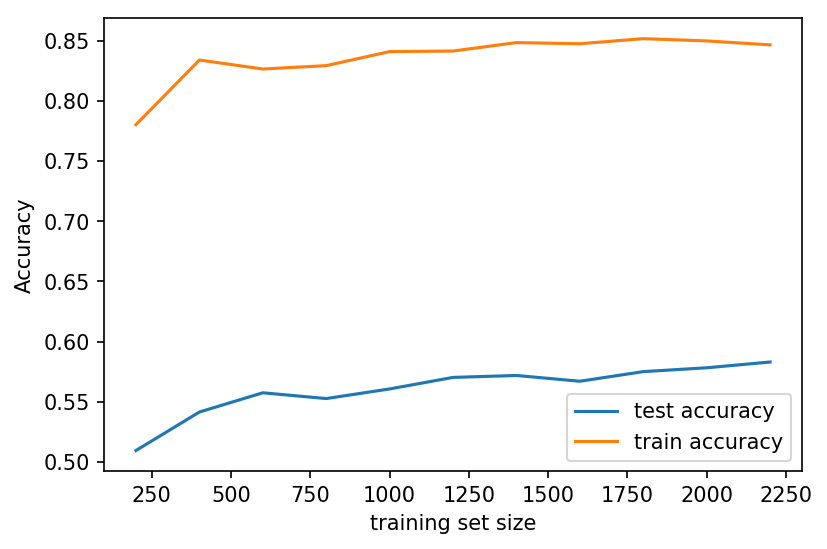

In [17]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 150

test_accuracy = []
train_accuracy=[]
size_settings = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]
parameter_C=[]

for size in size_settings:
    logreg_pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=123))
    param_grid = {'logisticregression__C': np.logspace(-6,3,14)}
    grid = GridSearchCV(logreg_pipe, param_grid, cv=5)
    grid.fit(X_train_dem[:size], y_train_dem[:size])
    test_accuracy.append(grid.score(X_TEST_dem, y_TEST_dem))
    train_accuracy.append(grid.score(X_train_dem, y_train_dem))
    parameter_C.append(grid.best_params_['logisticregression__C'])


    

plt.plot(size_settings, test_accuracy, label="test accuracy")
plt.plot(size_settings, train_accuracy, label="train accuracy")
plt.ylabel("Accuracy")
plt.xlabel("training set size")
plt.legend()

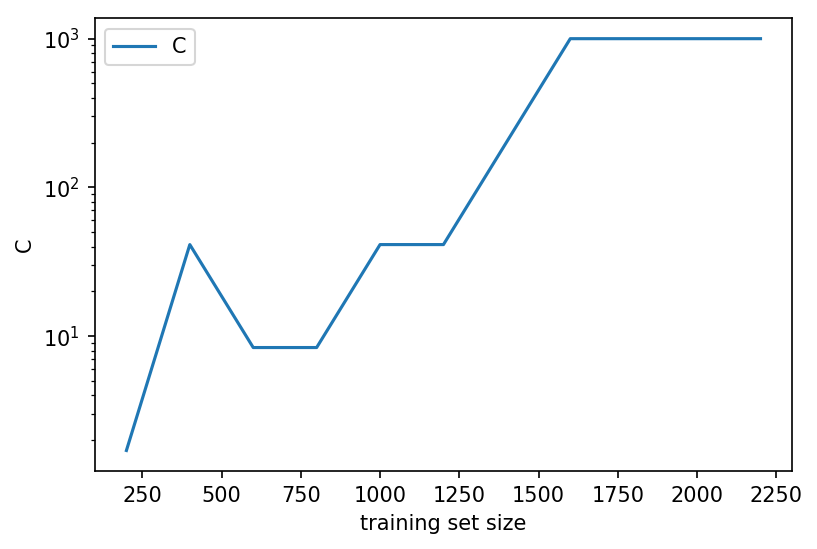

In [18]:
plt.plot(size_settings, parameter_C, label="C")
plt.ylabel("C")
plt.yscale('log')
plt.xlabel("training set size")
plt.legend()

# Feature Importance
3) Third, show which features are most important to make good predictions.

(-1, 51)

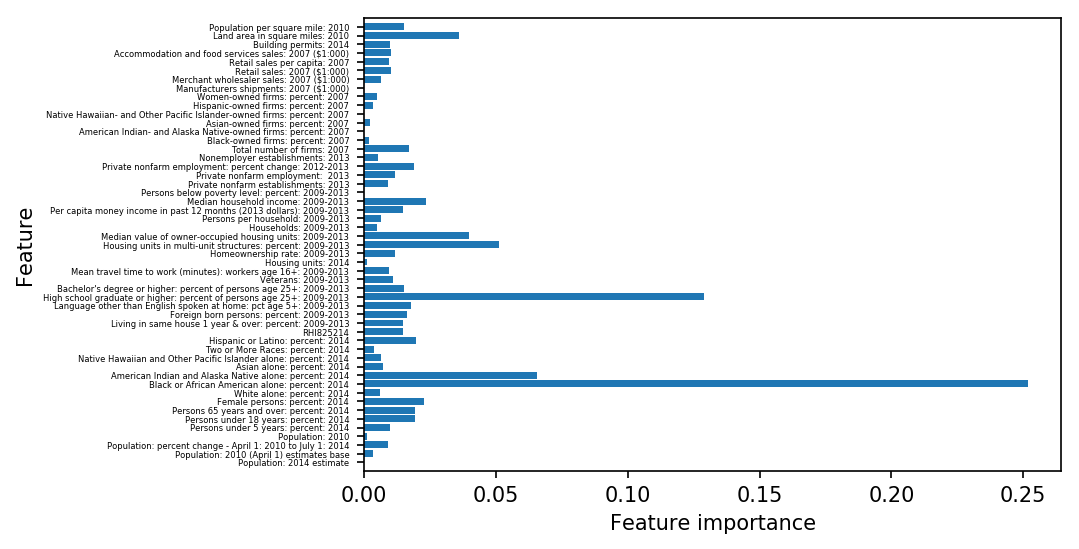

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train_dem, y_train_dem)

n_features = len(list(X_train_dem))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), list(X_train_dem), fontsize=4)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

# Final Evaluation 

In [20]:
logreg_pipe = make_pipeline(PolynomialFeatures(), MinMaxScaler(), LogisticRegression(random_state = 123))
param_grid = {'logisticregression__C': np.logspace(-6, 3, 14)}
grid = GridSearchCV(logreg_pipe, param_grid, cv = 5)
grid.fit(X_train_dem, y_train_dem)
print('The best performance: {:.3f}'.format(grid.score(X_TEST_dem, y_TEST_dem)))

The best performance: 0.578
